In [12]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

import yastn
from yastn.tn import mps

In [13]:
g = 1
v, Q = 1, 1
N = 256
D = 128
a = 0.125
m = 0.5
#
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/state_t=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fns = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", "dt=0.0625", f"{N=}", f"{D=}", f"{a=:0.4f}", f"{m=:0.4f}"])])

In [3]:
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/ex/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fex = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
fex

['/home/marek/pdf/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/ex/state_D=128.npy']

In [4]:
glob_path = os.path.join(os.path.abspath(""), "./results_fermions/g=1.0000/**/gs/**/state_D=*.npy")
fnames = glob.glob(glob_path, recursive=True)
fgs = sorted([fname for fname in fnames if all(x in fname for x in ["/g=1.0000/", f"{N=}", f"{a=:0.4f}", f"{D=}", f"{m=:0.4f}"])])
fgs

['/home/marek/pdf/./results_fermions/g=1.0000/m=0.5000/N=256/a=0.1250/gs/state_D=128.npy']

In [5]:
def fn_mass(fns, **kwargs):
    return [x for x in fns if all( f"{k}={v}" in x for k, v in kwargs.items()) ][0]

In [6]:
d_ex = np.load(fn_mass(fex, m=m), allow_pickle=True).item()
d_gs = np.load(fn_mass(fgs, m=m), allow_pickle=True).item()
psi_ex = yastn.from_dict(d_ex['psi'])
psi_gs = yastn.from_dict(d_gs['psi'])

In [7]:
prob_t = {}
ts = np.linspace(0, 16, 17)
for t in ts:
    x = np.load(fn_mass(fns, t=t), allow_pickle=True).item()
    psi_t = yastn.from_dict(x['psi'])
    prob_t[t] = np.abs(mps.vdot(psi_t, psi_ex)) ** 2

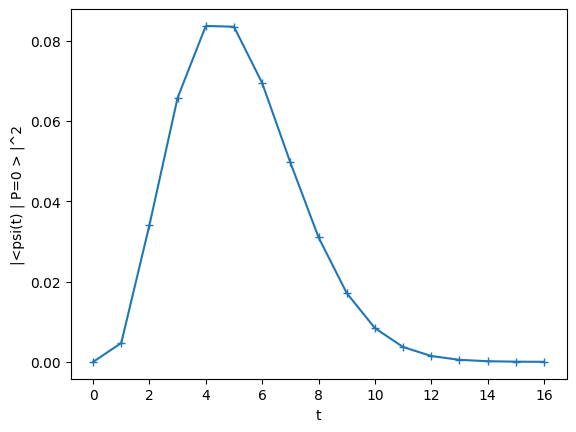

In [9]:
prob = [prob_t[t] for t in ts]
plt.plot(ts, prob, '-+')
plt.xlabel('t')
plt.ylabel("|<psi(t) | P=0 > |^2");